This notebook takes 2 signals/images. The intrinsic signal is given in the "intrinsic_func".

In [332]:
%reset -f
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np

In [333]:
def kernel(a, b,l):
    sqd=np.subtract.outer(a,b)**2
    return np.exp(-0.5*sqd/(l*l))

def get_GP_mean(tp,P,t,l):
    K=kernel(tp,tp,l);       #NPxNP
    Ks=kernel(tp,t,l);       #NPxN
    L=np.linalg.cholesky(K)# + 1e-15*np.eye(NP)); #NPxNP
    Lk=np.linalg.solve(L,Ks);      #NPxN
    z=np.linalg.solve(L,P);        #NP
    m=np.dot(Lk.T,z)   # ((Lk)')*z;// N
    return m;

In [334]:
%matplotlib inline
np.random.seed(15)
tk=10.0
def intrinsic_func(t,mu,dt):
    t1=t+dt;
    t1[t1<0]=0
    return mu*(t1)**2*np.exp(-(t1)/tk)

t_max=100.0; t_min=0.0; t_range=t_max-t_min; Ndata=200;
t=t_min+np.random.rand(Ndata)*t_range;t=np.sort(t);
#a slight shift is given because fitting may have problem with a very small \sigma 
print(np.amin(t), np.amax(t))

0.16447577600704477 99.8543402727172


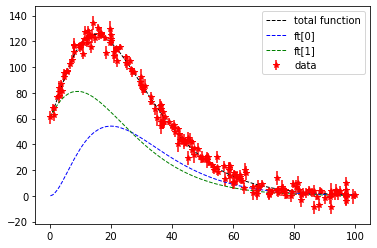

chi^2: if actual model: chi^2= 201.93980717339545


In [335]:
#mu and dt for the images
mu_l=[1.0,1.5]
dt_l=[0.0,11.0]
#for simplicity just consider the 1st NI images for now
NI=2; #just take two signal/image 
ft=np.zeros((NI,Ndata))

for i in np.arange(NI): 
    ft[i]=intrinsic_func(t,mu_l[i],dt_l[i])
    
ft_total=np.sum(ft,axis=0)
#sigft=0.05*ft_total+1.0  #10*(0.2+np.random.rand(len(t)))
sigft=5*(0.2+np.random.rand(len(t)))
np.random.seed(37)

y=np.random.normal(ft_total, sigft)#this is my data

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c","orange"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"ft[%d]"%(i))

plt.legend(loc=0)
plt.show()
chi2_am=np.sum(((y-ft_total)/sigft)**2)
print("chi^2: if actual model: chi^2=",chi2_am)

Using GP mean function instead of interpolation

We choose NP number of free parameters P. They represent the first image. The 2nd image is scaled by mu and has time delay dt (positive dt means the image shifted towards left, hence arrives earlier). To construct the first signal from the values of the parameters P we use GP mean function.

First we use NP=10, so 10 free nodes.

In [336]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
    vector[NP] tp;
    real td;
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=150.0> [NP] P;
    real<lower=5.0, upper=20.0> l;
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    //simplex[ni] dt_r;
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}
/*
//transformed parameters {
//    positive_ordered[ni-1] dt = dt_max*cumulative_sum(dt_r[:ni-1]);
//}*/

model {
    vector[N] dum;

    //dum needs GP
    dum=GP_mean(tp, t, P, l, NP, N); //first image
    dum=dum+mu*GP_mean(tp, t+dt, P, l, NP, N); //adding the 2nd image
    
    
    target+=normal_lpdf(y|dum,yerror);

}
"""
NI=2
NP=10;
dt_min=0.0; dt_max=20.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min, t_max+dt_max, NP)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'N': len(t),'ni':NI,'NP':NP, 't': t, 'y': y, 'yerror':sigft,'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit4 = sm.sampling(data=data, iter=2500, chains=8, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08b3e68d2d19a7c101786d460582b0d8 NOW.


tp= [  0.          13.33333333  26.66666667  40.          53.33333333
  66.66666667  80.          93.33333333 106.66666667 120.        ]
td= 13.333333333333334


Inference for Stan model: anon_model_08b3e68d2d19a7c101786d460582b0d8.
8 chains, each with iter=2500; warmup=400; thin=3; 
post-warmup draws per chain=700, total post-warmup draws=5600.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P[1]   31.31    0.22   6.17  19.15  27.41  31.28  35.34  43.13    821   1.01
P[2]   93.77    0.26   5.61  81.36  90.14  94.83   98.2 101.87    454   1.03
P[3]   79.12    0.18    4.4  68.84  76.39  79.75  82.45  85.78    568   1.02
P[4]   44.36    0.09   2.51  38.41  42.85   44.7  46.27  48.15    723   1.02
P[5]   20.17    0.04   1.25   17.5  19.39  20.28  21.06  22.26    837   1.02
P[6]    7.74    0.02   0.71   6.34   7.25   7.75   8.22   9.13   1271   1.01
P[7]    2.13    0.01   0.58   1.04   1.74   2.14   2.51   3.29   1749   1.01
P[8]    1.23    0.01   0.63   0.13   0.76   1.19   1.65   2.56   2215    1.0
P[9]    6.17    0.12   5.58   0.16   1.88   4.55   8.96   20.8   2031    1.0
P[10]  69.89    0.67  33.01  10.61  45.61  

In this notebook, we always plot the mean of the samples to get an idea about the sampling.

14 [31.31374136 93.77180472 79.1188775  44.35633799 20.17001874  7.73597412
  2.13455649  1.22736017  6.16540447 69.88587133]
P's are calculated at t=  [  0.          13.33333333  26.66666667  40.          53.33333333
  66.66666667  80.          93.33333333 106.66666667 120.        ]


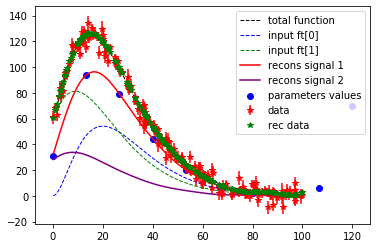

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 194.63642298629833


In [337]:
NP=10
tp=np.linspace(t_min, t_max+dt_max, NP)
pp1=fit4.get_posterior_mean()
pos_mean=np.mean(pp1,axis=1)
P_mean=pos_mean[np.arange(0,NP)]; 
print(len(pos_mean),P_mean)
lm=pos_mean[-4]; mum=pos_mean[-3]; dtm=pos_mean[-2];
print("P's are calculated at t= ",tp)


Ps1=get_GP_mean(tp,P_mean,t,lm)
Ps2=mum*get_GP_mean(tp,P_mean,t+dtm,lm)

rconst_signal=Ps1+Ps2#+Ps3+Ps4;
Ps=Ps1+Ps2

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c","orange"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"input ft[%d]"%(i))

plt.plot(t,Ps1,c="r",label="recons signal 1" )  
plt.plot(t,Ps2,c="purple",label="recons signal 2") 
plt.errorbar(t,Ps,fmt='g*',label=r"rec data") #data    
plt.scatter(tp,P_mean,c='b',label="parameters values")
plt.legend(loc=0)
plt.show()
chisq=np.sum((Ps-y)**2/sigft**2)
chisq_o=np.sum((ft_total-y)**2/sigft**2)
print("Chi^2 actual=",chisq_o,"Chi^2 pystan rec=",chisq)

We are not getting the correct individual images, although the overall fitting to the combined images are good.

Below we use NP=11 

In [338]:

model = """
functions{
    matrix kernel(vector x0, vector x1, real l){
        int d0=num_elements(x0);
        int d1=num_elements(x1);
        matrix [d0,d1] a;
        for (i in 1:d0){
            for (j in 1:d1){
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                //a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel(tp,tp,l);       //NPxNP
        Ks=kernel(tp,t,l);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
}

data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
    vector[NP] tp;
}
parameters {
    vector <lower=0.0, upper=150.0> [NP] P;
    real<lower=5.0, upper=20.0> l;
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    //simplex[ni] dt_r;
    real <lower=0.0, upper=20.0> dt;
    
    
    
    
}
/*
//transformed parameters {
//    positive_ordered[ni-1] dt = dt_max*cumulative_sum(dt_r[:ni-1]);
//}*/

model {
    vector[N] dum;

    //dum needs GP
    dum=GP_mean(tp, t, P, l, NP, N);
    dum=dum+mu*GP_mean(tp, t+dt, P, l, NP, N);
    
    
    target+=normal_lpdf(y|dum,yerror);

}
"""
NI=2
NP=11;
dt_min=0.0; dt_max=20.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min, t_max+dt_max, NP)
print(tp)
data = {'N': len(t),'ni':NI,'NP':NP, 't': t, 'y': y, 'yerror':sigft,'tp':tp}

sm = pystan.StanModel(model_code=model)

fit5 = sm.sampling(data=data, iter=2500, chains=8, warmup=400, thin=3, seed=4201)
print(fit5)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9423764983a099dc83839dac905495c9 NOW.


[  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120.]


Inference for Stan model: anon_model_9423764983a099dc83839dac905495c9.
8 chains, each with iter=2500; warmup=400; thin=3; 
post-warmup draws per chain=700, total post-warmup draws=5600.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P[1]   30.46    0.79   8.49  13.26  24.67  31.08  36.77  44.65    114   1.06
P[2]   89.73     0.6   6.52  75.94  85.22  90.72  95.11  99.17    118   1.06
P[3]   84.72    0.37   5.32  73.84  81.18  85.36  88.76  93.31    207   1.04
P[4]   53.62    0.22   3.31  46.69  51.64  53.97  56.06  59.01    230   1.04
P[5]   27.67    0.12   1.85  23.88  26.48  27.82  29.01  30.95    224   1.04
P[6]   13.27    0.06   1.06  10.95  12.57  13.34   14.0  15.19    371   1.02
P[7]     4.0    0.02   0.66   2.73   3.56   3.99   4.45   5.23   1018   1.01
P[8]    2.43    0.02   0.69    1.1   1.98    2.4   2.89   3.83   1880    1.0
P[9]    0.65    0.01   0.48   0.03   0.27   0.57   0.95   1.77   2211    1.0
P[10]   6.37    0.27   6.11   0.19   1.92  

[ 3.04591204e+01  8.97270122e+01  8.47202294e+01  5.36161577e+01
  2.76738050e+01  1.32654013e+01  3.99630890e+00  2.43056629e+00
  6.52790032e-01  6.36685905e+00  3.82920571e+01  1.44185688e+01
  3.78104567e-01  8.73593071e+00 -4.94525910e+02]
15 11
P's are calculated at t=  [  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120.]


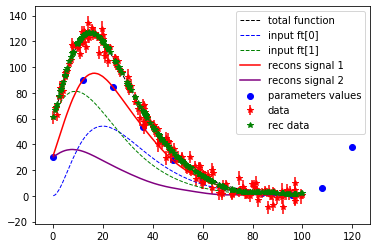

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 202.52406680203737


In [339]:
NP=11
tp=np.linspace(t_min, t_max+dt_max, NP)
pp1=fit5.get_posterior_mean()
pos_mean=np.mean(pp1,axis=1)
P_mean=pos_mean[np.arange(0,NP)]; 
print(pos_mean)
print(len(pos_mean),len(P_mean))
lm=pos_mean[-4]; mum=pos_mean[-3]; dtm=pos_mean[-2];
print("P's are calculated at t= ",tp)


Ps1=get_GP_mean(tp,P_mean,t,lm)
Ps2=mum*get_GP_mean(tp,P_mean,t+dtm,lm)

rconst_signal=Ps1+Ps2#+Ps3+Ps4;
Ps=Ps1+Ps2

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c","orange"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"input ft[%d]"%(i))

plt.plot(t,Ps1,c="r",label="recons signal 1")  
plt.plot(t,Ps2,c="purple",label="recons signal 2") 
plt.errorbar(t,Ps,fmt='g*',label=r"rec data") #data    
plt.scatter(tp,P_mean,c='b',label="parameters values")
plt.legend(loc=0)
plt.show()
chisq=np.sum((Ps-y)**2/sigft**2)
chisq_o=np.sum((ft_total-y)**2/sigft**2)
print("Chi^2 actual=",chisq_o,"Chi^2 pystan rec=",chisq)

We get somewhat similar result. The overall fit is good, but the original two signals are not resolved correctly.